In [50]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from utils import ECDF, despine_traceplot
from data import load_decay
import pandas as pd
import theano.tensor as tt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

Now that you've learned about Bayesian estimation, we're going to explore one more topic: Bayesian curve fitting.

By "curve fitting", we're really talking about any curve: those that are bendy, those that are straight, and those that are in between. 

In order to reinforce this point, rather than show you plain vanilla linear regression, we will work through an exponential decay curve example.

# Problem Setup

You've taken radioactive decay measurements of an unknown element in a secure facility. The measurements are noisy, though, and potentially have some bias. In the face of this, we would like to be able to characterize the decay constant of this unknown material, potentially leading to an identification of the material.

Let's load in the data.

In [42]:
np.random.seed(42)

df = load_decay()
df.head(5)

,t,activity
0,0,62.496714
1,1,61.033020
2,2,61.001703
3,3,61.071062
4,4,58.519029


**Exercise:** Plot `activity` vs. `time`.

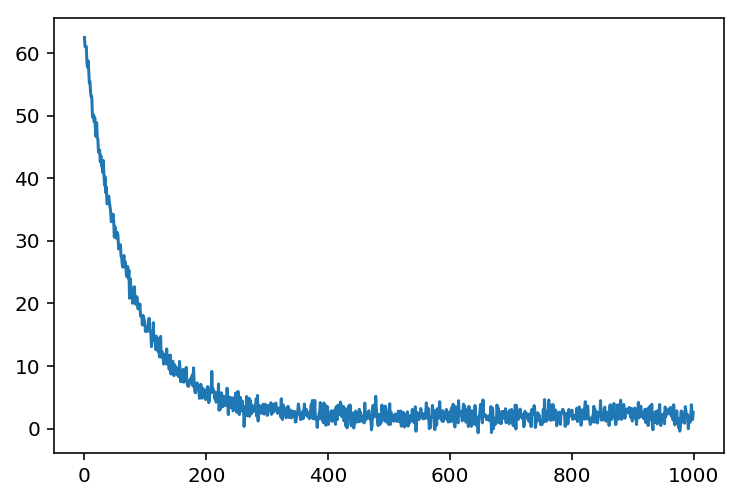

In [49]:
ax = df['activity'].plot()
# ax.set_ylim(30, 40)

**Discuss:** 

- For the scenario that we're in, what is a plausible equation that links time to activity?
- What are the key parameters that we need to worry about?
- What might be justifiable priors for them?

**Exercise:** Implement the model.

In [44]:
with pm.Model() as model:
    A = pm.HalfNormal('A', sd=100)
    tau = pm.Exponential('tau', lam=1)
    C = pm.Normal('C', sd=100)
    
    sd = pm.HalfCauchy('sd', beta=1)
    
    link = A * np.exp(-df['t'].values / tau) + C
    
    like = pm.Normal('activity', mu=link, sd=sd, observed=df['activity'].values)

Sample from the posterior.

In [47]:
with model:
    trace = pm.sample(2000, tune=2000)
    # Note: Sampler may pause for a while after finishing

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, C, tau_log__, A_log__]
100%|██████████| 4000/4000 [00:08<00:00, 450.39it/s]


Check that sampling has converged.

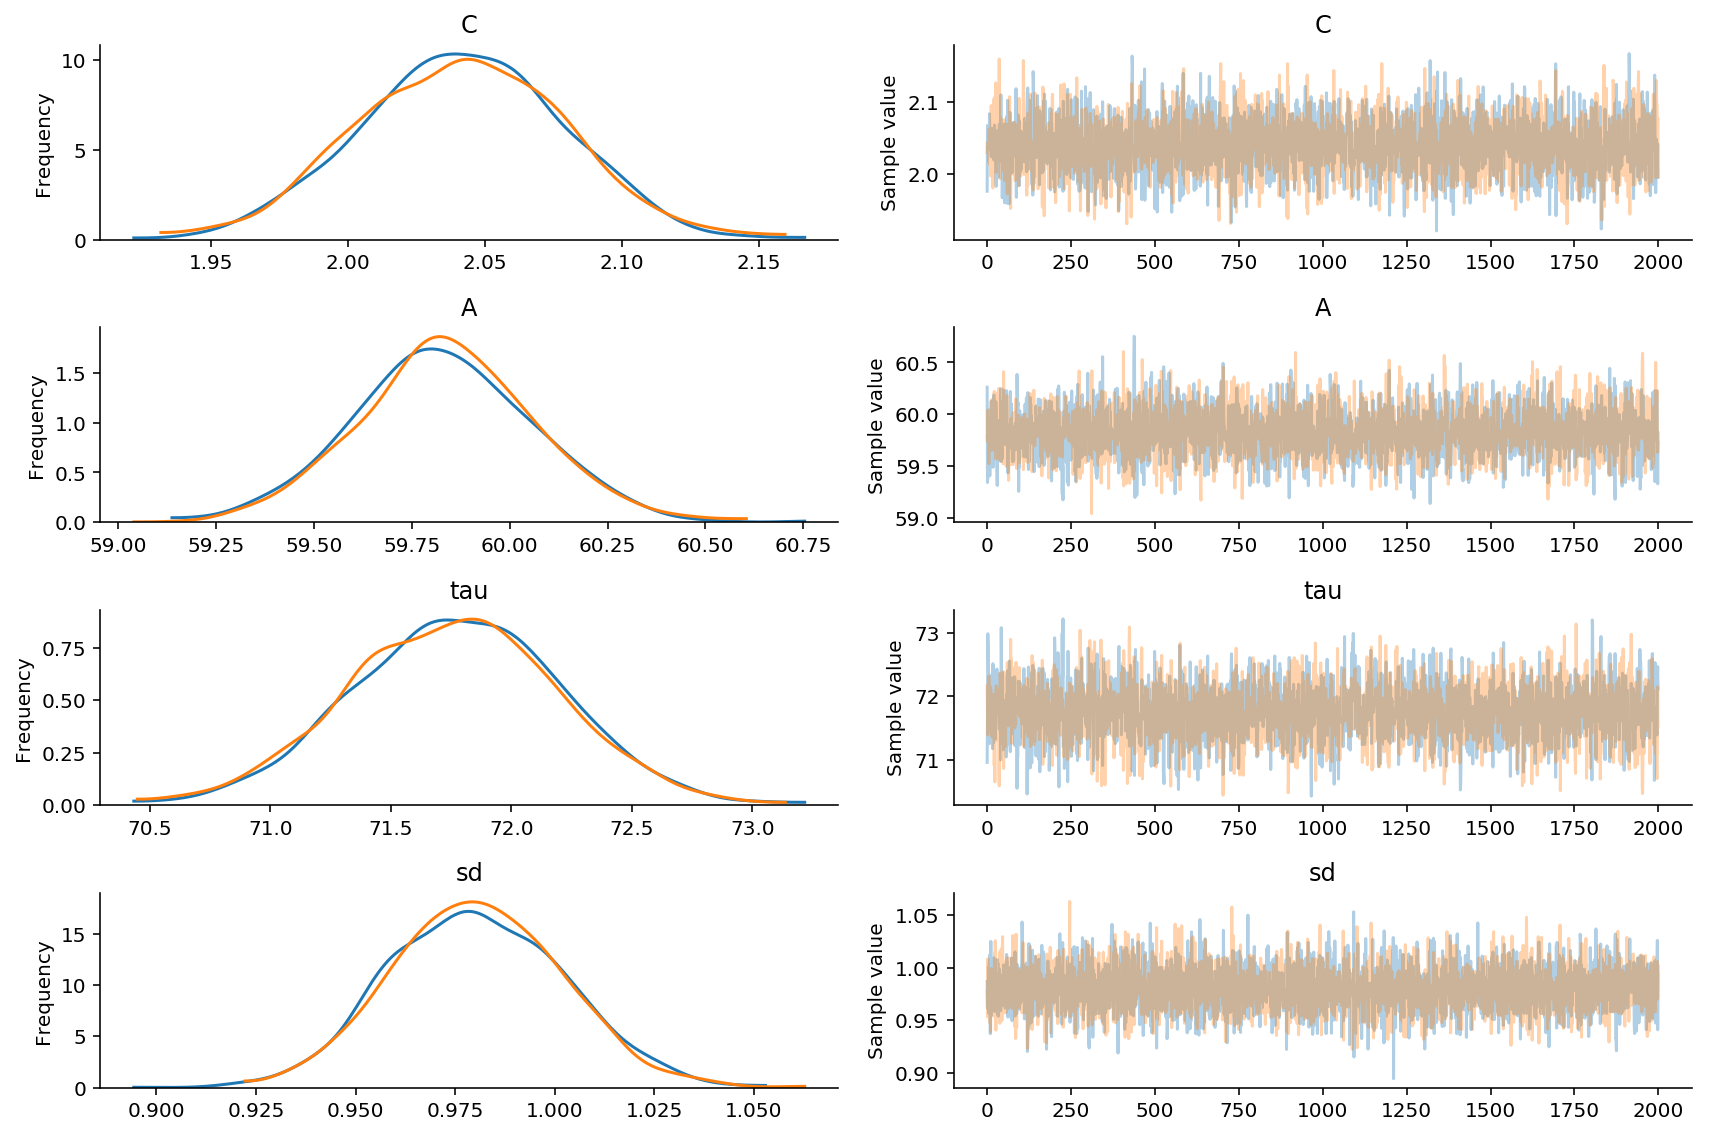

In [52]:
traces = pm.traceplot(trace)
despine_traceplot(traces)

# Summary

- In lieu of showing you a "straight curve" (line) fit, you've now seen an arbitrary curve fit.
- As long as you can find a way to parameterize the curve with a function, you can perform inference on the curve's parameters.
- The function that you are modelling is the "link function" that provides the link between the parameters, data and the output.

More generally, if

$$y = f(x, \theta)$$

where $\theta$ are merely a set of parameters, then you can perform inference on the curve's parameters $\theta$. To make this clear:

| curve name | functional form | parameters $\theta$ |
|------------|-----------------|---------------------|
| exponential decay | $y = Ae^{-t/\tau} + C$ | $A$, $\tau$, $C$|
| linear regression | $y = mx + c$ | $m$, $c$ |
| logistic regression | $y = L(mx + c)$ | $m$, $c$ |
| 4-parameter IC50 | $y = \frac{a - i}{1 + 10^{\beta(log(\tau) - x)}} + i$ | $a$, $i$, $\tau$, $\beta$ |
| deep learning | $y = f(x, \theta)$ | $\theta$ |